In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data

path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info
ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2022.08.18_ALL.txt", sep='\t',encoding='cp1252')
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
PSPCBD = pd.read_csv(path + "PSPCBDPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
SUBJ_drop = pd.read_excel(path + 'ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## SUBJID and SampleID are not 1-1 match

print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

51992
56863


In [4]:
print(ADNI.shape, family_based.shape, case_control.shape, PSPCBD.shape)

(1566, 31) (12858, 27) (45375, 31) (2803, 17)


In [43]:
print(ADNI.columns)
print(family_based.columns)
print(case_control.columns)
print(PSPCBD.columns)

Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age_current', 'Age_baseline',
       'Age_MCI_onset', 'Age_AD_onset', 'APOE_reported', 'APOE_WGS', 'AUTOPSY',
       'Braak', 'Race', 'Ethnicity', 'AD_last_visit', 'MCI_last_visit',
       'Duplicate_SUBJID', 'Comments', 'Latest_Update_Version', 'Base_PrevAD',
       'Base_IncAD', 'Base_Age', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD',
       'Base_MCI', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_Diagnosis', 'Correction'],
      dtype='object')
Index(['SUBJID', 'FamID', 'Father', 'Mother', 'Sex', 'AD', 'Age',
       'Age_baseline', 'APOE_reported', 'APOE_WGS', 'AUTOPSY', 'Braak', 'Race',
       'Ethnicity', 'FamGrp', 'Comments', 'Duplicate_SUBJID',
       'Latest_Update_Version', 'Base_AD', 'Base_Age', 'Base_AUTOPSY',
       'Base_Braak', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_ADstatus', 'Correction'],
      dtype='object')
Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age', 'Age_baseline',
     

In [5]:
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]

In [6]:
## There are two cases without age of onset

print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull().sum())
print(ADNI_processed[ADNI_processed.AD_last_visit == 1][ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull()])
print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_baseline.isnull().sum())

## all controls have current age and the age they first entered the study!
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_current.isnull().sum()
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_baseline.isnull().sum()

2
              SUBJID  Sex Age_current Age_AD_onset Age_baseline  \
871  G-ADNI-AN000064    0          66          NaN           61   
975  G-ADNI-AN000170    0          76          NaN           73   

     APOE_reported  Race  AD_last_visit  
871             33   5.0              1  
975             34   5.0              1  
0


0

In [7]:
## ADNI
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]
## fill the age of controls
ADNI_processed['Age_AD_onset'] = ADNI_processed['Age_AD_onset'].fillna(ADNI_processed['Age_current'])
ADNI_processed.rename(columns = {'Age_AD_onset':'Age', 'AD_last_visit':'Diagnosis'}, inplace = True)
ADNI_processed = ADNI_processed.drop(columns=['Age_current']).dropna()

In [8]:
## family_based

family_based['Diagnosis'] = 'NaN'
control = family_based[(family_based['AD'] == 0)| (family_based['AD'] == 10)].copy()
case = family_based[(family_based['AD'] >=1) & (family_based['AD'] <=4)].copy()

control.loc[:,["Diagnosis"]] = 0
case.loc[:,["Diagnosis"]] = 1
family_based = pd.concat([control,case])
family_based_processed = family_based.loc[:, ["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race", "Age_baseline"]]
print(family_based_processed.shape)

(6624, 7)


In [9]:
family_based_processed.isna().sum()


SUBJID              0
Sex                 0
Diagnosis           0
APOE_reported    2520
Age              2011
Race             1262
Age_baseline     2821
dtype: int64

In [10]:
family_based_processed = family_based_processed.dropna(subset = ['Age', 'APOE_reported', 'Race'])

In [11]:
## case_control

case_control_processed = case_control.loc[:,["SUBJID", "Sex", "AD", "APOE_reported","Age","Race", "Age_baseline"]]
case_control_processed = case_control_processed.rename(columns = {'AD':'Diagnosis'})

print(case_control_processed.isna().sum())
case_control_processed = case_control_processed.dropna(subset = ['Diagnosis','Age', 'APOE_reported', 'Race'])

SUBJID               0
Sex                  1
Diagnosis         5235
APOE_reported     5776
Age               4833
Race              2728
Age_baseline     18367
dtype: int64


In [12]:
print(case_control_processed.shape, case_control.shape)

(32644, 7) (45375, 31)


In [173]:
PSPCBD

,SUBJID,Sex,Diagnosis,AgeOnset,AgeDeath,Race,APOE_WGS,Duplicate_SUBJID,Comments,Latest_Update_Version,Base_Diagnosis,Base_Version,Update_Baseline,Update_Latest,Update_Diagnosis,Correction,Consent
0,P-ABN-CBD6614,1,2,67,73,5.0,NaN,0,NaN,ng00067.v2,2,ng00067.v2,0,0,0,0,GRU-IRB-PUB
1,P-ABN-PSP5079,1,1,71,76,NaN,33.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
2,P-ABN-PSP5080,1,1,68,73,NaN,34.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
3,P-ABN-PSP5081,0,1,72,75,NaN,33.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
4,P-ABN-PSP5082,1,1,68,73,NaN,24.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,P-WZB-PSP10181,0,1,74,82,5.0,33.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
2799,P-WZB-PSP10182,0,1,79,76,5.0,33.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
2800,P-WZB-PSP5049,0,1,63,70,5.0,33.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB
2801,P-WZB-PSP5050,0,1,56,62,5.0,34.0,0,NaN,ng00067.v5,1,ng00067.v5,0,1,0,0,GRU-IRB-PUB


In [13]:
ADNI_processed["source"] = 'ADNI'
family_based_processed["source"] = 'Family_based'
case_control_processed["source"] = 'case_control'

In [14]:
pheno = pd.concat([ADNI_processed, family_based_processed, case_control_processed])

In [70]:
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.Age = pheno.Age.astype('int')

In [64]:
pheno

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87.0,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90.0,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68.0,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69.0,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82.0,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
42341,G-KGAD-KA001265,1.0,56.0,76,34.0,5.0,1.0,case_control
42342,G-KGAD-KA001266,0.0,70.0,72,34.0,5.0,1.0,case_control
42343,G-KGAD-KA001267,0.0,60.0,62,34.0,5.0,1.0,case_control
42344,G-KGAD-KA001268,0.0,70.0,77,34.0,5.0,1.0,case_control


In [61]:
pheno.isna().sum()

SUBJID               0
Sex                  0
Age                  0
Age_baseline     14633
APOE_reported        0
Race                 0
Diagnosis            0
source               0
dtype: int64

In [16]:
pheno[pheno.SUBJID.duplicated()].shape

(112, 8)

In [65]:
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID

In [18]:
pheno.shape

(38276, 8)

In [19]:
duplicated_ID ## the duplicate ones 

16132    A-CUHS-CU000018
16133    A-CUHS-CU000169
16134    A-CUHS-CU000194
16135    A-CUHS-CU000387
16136    A-CUHS-CU000563
              ...       
31381     A-RAS-RA000012
31383     A-RAS-RA000016
31386     A-RAS-RA000020
31388     A-RAS-RA000022
33405     A-VAN-VU000119
Name: SUBJID, Length: 112, dtype: object

In [71]:
pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID')

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
2552,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,Family_based
16132,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control
2683,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,Family_based
2704,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,Family_based
...,...,...,...,...,...,...,...,...
12239,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,Family_based
12243,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,Family_based
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
11583,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,Family_based


In [219]:
## The duplicates are between family based and case control, two as a pair
print(min(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))
print(max(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))

2
2


In [86]:
duplicates = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID', ascending = False)


In [74]:
not_identitcal_duplicates = duplicates.drop_duplicates(subset = ['SUBJID','Sex', 'Age', 'Age_baseline', 'APOE_reported'],keep = False)   

In [51]:
not_identitcal_duplicates.shape

(64, 8)

Text(0, 0.5, 'count')

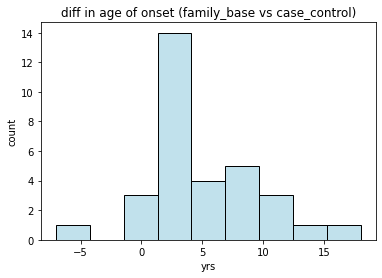

In [96]:
ax = sns.histplot(not_identitcal_duplicates.sort_values('source', ascending = False).groupby('SUBJID')['Age'].diff(), color = 'lightblue')
plt.title('diff in age of onset (family_base vs case_control)')
plt.xlabel('yrs')
plt.ylabel('count')
#

In [104]:
## except for age of onset, all the other columns are the same

not_identitcal_duplicates.groupby("SUBJID").Diagnosis.mean()

SUBJID
A-LOAD-LD000600    1.0
A-LOAD-LD000909    1.0
A-LOAD-LD001254    1.0
A-LOAD-LD001837    1.0
A-LOAD-LD002391    1.0
A-LOAD-LD002680    1.0
A-LOAD-LD002888    1.0
A-LOAD-LD003169    1.0
A-LOAD-LD003529    1.0
A-LOAD-LD003545    1.0
A-LOAD-LD003745    1.0
A-LOAD-LD004108    1.0
A-LOAD-LD004308    1.0
A-LOAD-LD004469    1.0
A-LOAD-LD004488    1.0
A-LOAD-LD004827    1.0
A-LOAD-LD005185    1.0
A-LOAD-LD005225    1.0
A-LOAD-LD005331    1.0
A-LOAD-LD007435    1.0
A-LOAD-LD007980    1.0
A-LOAD-LD010801    1.0
A-LOAD-LD010944    1.0
A-LOAD-LD011473    1.0
A-LOAD-LD011540    1.0
A-LOAD-LD011716    1.0
A-RAS-RA000001     1.0
A-RAS-RA000005     1.0
A-RAS-RA000009     1.0
A-RAS-RA000011     1.0
A-RAS-RA000012     1.0
A-RAS-RA000016     1.0
Name: Diagnosis, dtype: float64

In [105]:
not_identitcal_duplicates[not_identitcal_duplicates.SUBJID == 'A-LOAD-LD007980']

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
8024,A-LOAD-LD007980,0.0,58,58,34.0,5.0,1.0,Family_based
20654,A-LOAD-LD007980,0.0,65,58,34.0,5.0,1.0,case_control


In [113]:
not_identitcal_duplicates = not_identitcal_duplicates[(not_identitcal_duplicates['source'] == 'case_control') & (not_identitcal_duplicates.SUBJID != 'A-LOAD-LD007980')] ## 31 rows

In [124]:
#not_identitcal_duplicates["Age_baseline"] = not_identitcal_duplicates.Age_baseline.fillna(not_identitcal_duplicates["Age"])

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control')]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
33405,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,case_control
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
31386,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,case_control
28806,A-NCRD-NC017018,1.0,73,NaN,34.0,5.0,1.0,case_control
28734,A-NCRD-NC007634,0.0,71,NaN,34.0,5.0,1.0,case_control
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [135]:
identical_duplicates = duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control') & (duplicates.SUBJID != 'A-LOAD-LD007980') ]

In [166]:
pheno_merge = pd.concat([pheno[(pheno.SUBJID != 'A-LOAD-LD007980') & (~pheno.SUBJID.isin(duplicated_ID))], not_identitcal_duplicates, identical_duplicates])

In [167]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [170]:
print(len(pheno_merge.SUBJID.unique()))
print(pheno_merge.isna().sum())

38163
SUBJID               0
Sex                  0
Age                  0
Age_baseline     14603
APOE_reported        0
Race                 0
Diagnosis            0
source               0
dtype: int64


In [171]:
pheno_merge[pheno_merge.Age_baseline.isnull()]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
1398,A-MIA-UM000061,1.0,87,NaN,23.0,5.0,0.0,Family_based
1399,A-MIA-UM000063,0.0,71,NaN,33.0,5.0,0.0,Family_based
1405,A-MIA-UM000341,1.0,74,NaN,34.0,5.0,0.0,Family_based
1410,A-MIA-UM000383,0.0,47,NaN,33.0,5.0,0.0,Family_based
1411,A-MIA-UM000387,1.0,63,NaN,33.0,5.0,0.0,Family_based
...,...,...,...,...,...,...,...,...
24684,A-MIA-UM000679,1.0,83,NaN,34.0,5.0,1.0,case_control
24683,A-MIA-UM000666,0.0,59,NaN,34.0,5.0,1.0,case_control
24671,A-MIA-UM000336,1.0,72,NaN,34.0,5.0,1.0,case_control
24670,A-MIA-UM000329,0.0,73,NaN,34.0,5.0,1.0,case_control


In [172]:
pheno_merge.Age_baseline = pheno_merge.Age_baseline.fillna(pheno_merge.Age)

In [174]:
pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']] = pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']].astype(int)

In [175]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1,87,76,33,5,0,ADNI
1,ADNI_002_S_0685,1,90,89,33,5,0,ADNI
2,ADNI_002_S_0729,1,68,65,34,5,1,ADNI
3,ADNI_002_S_1155,0,69,57,33,5,0,ADNI
4,ADNI_002_S_1261,1,82,71,33,5,0,ADNI
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0,74,77,34,6,1,case_control
16135,A-CUHS-CU000387,1,87,71,23,6,0,case_control
16134,A-CUHS-CU000194,1,73,65,33,6,0,case_control
16133,A-CUHS-CU000169,1,87,84,33,5,0,case_control


In [177]:
pheno_merge.to_csv(path + 'phenotype_merged.tsv',sep = '\t', index = False)

In [180]:
SUBJ_drop


,SUBJID,SampleID
0,A-MAYO-MY000107,A-MAYO-MY000107-BL-MAY-570
1,A-MAYO-MY000168,A-MAYO-MY000168-BL-MAY-664
2,A-MAYO-MY000658,A-MAYO-MY000658-BL-MAY-1945
3,A-MPD-MP000002,A-MPD-MP000002-BR-NCR-11AD37339
4,A-MPD-MP000004,A-MPD-MP000004-BR-NCR-11AD37277
...,...,...
147,A-ADC-AD003737,A-ADC-AD003737-BL-NCR-09AD16503
148,A-ADC-AD005043,A-ADC-AD005043-BR-NCR-09AD15795
149,A-MIA-UM001976,A-MIA-UM001976-BL-MIA-20010205
150,A-MIA-UM000315,A-MIA-UM000315-BL-MIA-19961724


In [179]:
pheno[pheno.SUBJID.isin(SUBJ_drop)]


,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
